In [1]:
from GAE import GAE
from CAE import Autoencoder
import Get_data as Gd
import torch
import torch.nn as nn

import numpy as np
import scipy
import matplotlib.pyplot as plt

/home/scheng1/miniconda3/envs/wl4023/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Get test data

In [2]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [3]:
sparse_graph = scipy.sparse.load_npz('/data/Sibo_22Mar2024/sparse_matrix_fixed.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
edge_weight = edge_tensor.values()
print(edge_tensor.shape)
print(edge_index)
print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [4]:
folders = ['/data/Sibo_22Mar2024/case_18/hessian_']
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

# Load model

In [5]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

## Load GAE

In [6]:
lengthscales = [0.17, 1]  # 例如定义的长度比例
num_mp_layers = [2, 3]  # 例如定义的消息传递层数

bounding_box = []
if len(lengthscales) > 0:
    x_lo = pos[:,0].min() - lengthscales[0]/2
    x_hi = pos[:,0].max() + lengthscales[0]/2
    y_lo = pos[:,1].min() - lengthscales[0]/2
    y_hi = pos[:,1].max() + lengthscales[0]/2
    bounding_box = [x_lo.cpu(), x_hi.cpu(), y_lo.cpu(), y_hi.cpu()]

In [7]:
gae = GAE(1, 1, bounding_box, lengthscales, num_mp_layers, 16, 2)
criterion = RMSELoss()
metric = NRMSE(test_tensor)
# 加载保存的状态字典
state_dict = torch.load('/home/scheng1/wl4023/IRP/BaselineModels/GAE/GAE.pth', map_location=torch.device('cpu'))
gae.load_state_dict(state_dict)

<All keys matched successfully>

## Load CAE

In [8]:
cae = Autoencoder(1, 49)
# 加载保存的状态字典
state_dict = torch.load('/home/scheng1/wl4023/IRP/BaselineModels/CNN_LSTM/CAE.pth', map_location=torch.device('cpu'))
cae.load_state_dict(state_dict)
# model.to(device)

<All keys matched successfully>

# Prediction

In [9]:
criterion = RMSELoss()
metric = NRMSE(test_tensor)

## GAE

In [10]:
GAE_output = torch.zeros_like(test_tensor)
GAE_RMSEs = []
GAE_NRMSEs = []


for i in range(len(test_tensor_set)):
    GAE_output[i], _, _ = gae(test_tensor_set[i], edge_index, edge_weight, pos)

    rmse = criterion(test_tensor_set[i], GAE_output[i]).item()
    nrmse = metric(test_tensor_set[i], GAE_output[i]).item()

    GAE_RMSEs.append(rmse)
    GAE_NRMSEs.append(nrmse)

GAE_RMSEs = np.array(GAE_RMSEs)
GAE_NRMSEs = np.array(GAE_NRMSEs)

print(f"RMSE Loss: {GAE_RMSEs.mean()}, NRMSE Loss: {GAE_NRMSEs.mean()}")

RMSE Loss: 1.4776051092147826, NRMSE Loss: 0.03448804283514619


## CAE

In [11]:
CAE_output = torch.zeros_like(test_tensor)
CAE_RMSEs = []
CAE_NRMSEs = []


for i in range(len(test_tensor_set)):
    x = test_tensor_set[i].permute(1, 0)
    output = cae(x)

    CAE_output[i] = output.permute(0, 2, 1)

    rmse = criterion(test_tensor_set[i], CAE_output[i]).item()
    nrmse = metric(test_tensor_set[i], CAE_output[i]).item()

    CAE_RMSEs.append(rmse)
    CAE_NRMSEs.append(nrmse)

CAE_RMSEs = np.array(CAE_RMSEs)
CAE_NRMSEs = np.array(CAE_NRMSEs)

print(f"RMSE Loss: {CAE_RMSEs.mean()}, NRMSE Loss: {CAE_NRMSEs.mean()}")

RMSE Loss: 5.6498655772209165, NRMSE Loss: 0.13187069088220596


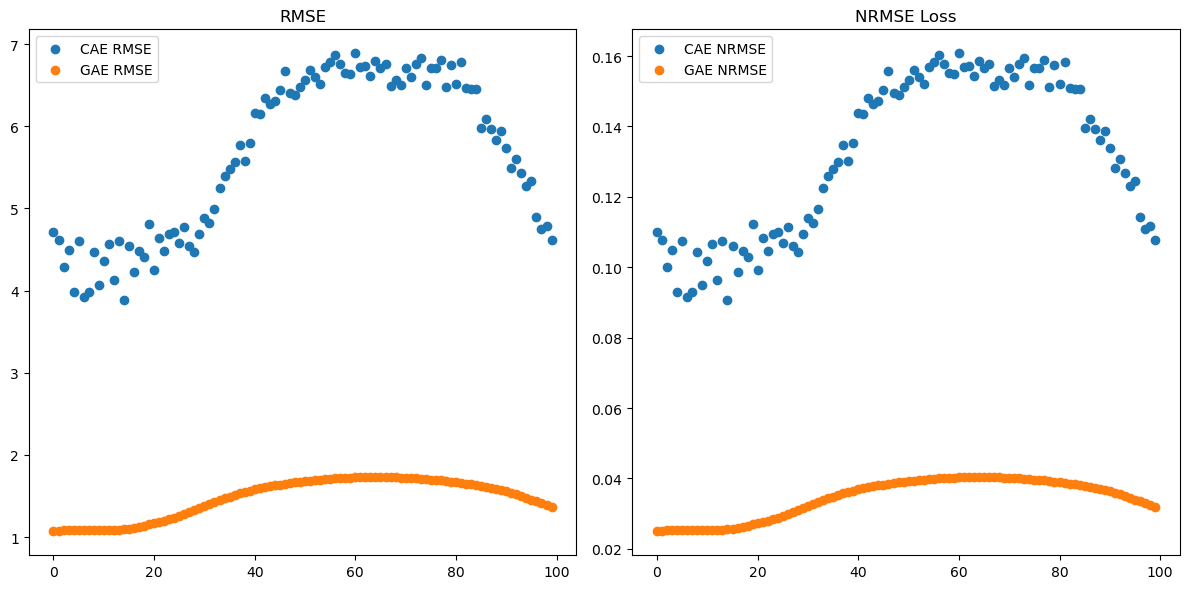

In [12]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

x = np.arange(0, 100)

axs[0].scatter(x, CAE_RMSEs, label='CAE RMSE')
axs[0].scatter(x, GAE_RMSEs, label='GAE RMSE')
axs[0].set_title("RMSE")
axs[0].legend()

axs[1].scatter(x, CAE_NRMSEs, label='CAE NRMSE')
axs[1].scatter(x, GAE_NRMSEs, label='GAE NRMSE')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠
plt.show()